# Logistic Regression Project Tutorial

In [2]:
#Importamos librerias

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib


df = pd.read_csv("/workspaces/Machine_learning_Vicente/data/raw/bank-marketing-campaign-data.csv", sep= ';' )

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no


Comprobamos el tamaño del Dataframe

In [3]:
df.shape

(41188, 21)

# Limpieza del DataSet

Comprobamos que no hay valores null viendo que el numero total es 41188

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Comprobamos la relevancia de las columnas y que no hay ninguna con un único valor. Comprobamos pues, que no hay columnas con tan solo un subnivel, por lo que no eliminamos ninguna 

In [5]:
n_unicos = df.nunique()
n_unicos

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

Revisamos las columnas numéricas. Dado que su desviación estandar no es igual a 0, lo cual mostraría que en la columna se repite un unico valor, no vamos a eliminar ninguna

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10


Revisamos que no hay duplicados. Los valores que se repiten se muestran por primera vez. 

In [7]:
duplicadas = df[df.duplicated(keep=False)]

duplicadas


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.40,93.92,-42.70,4.97,5228.10,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.40,93.92,-42.70,4.97,5228.10,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.40,93.92,-42.70,4.96,5228.10,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.40,93.92,-42.70,4.97,5228.10,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.40,93.92,-42.70,4.97,5228.10,no


Contamos los valores duplicados

In [8]:
df.duplicated().sum()

np.int64(12)

Eliminamos valores duplicados

In [9]:
print(f'Tamaño del set antes de eliminar las filas repetidas: {df.shape} ')
df.drop(df[df.duplicated()].index, inplace=True)
print(f'Tamaño del set despues de eliminar las filas repetidas: {df.shape} ')

Tamaño del set antes de eliminar las filas repetidas: (41188, 21) 
Tamaño del set despues de eliminar las filas repetidas: (41176, 21) 


Comprobamos si hay valores faltantes con matriz

<Axes: >

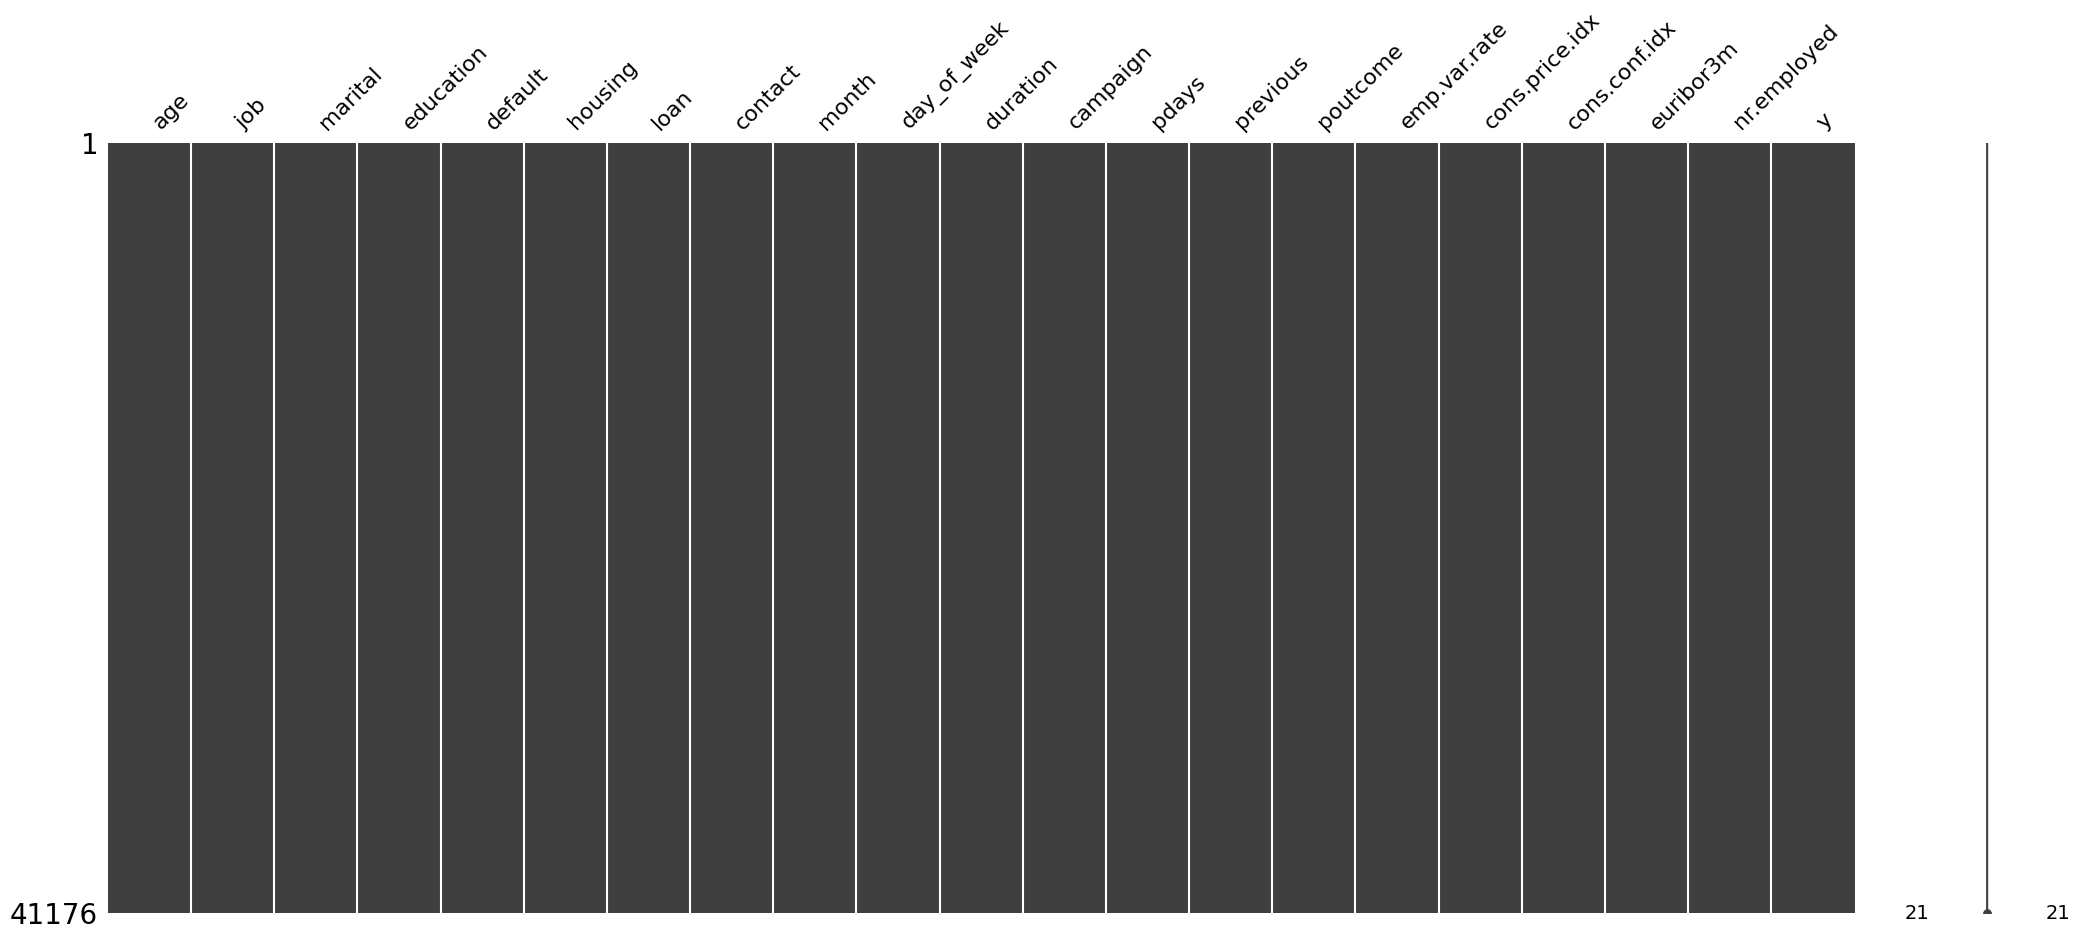

In [10]:
msno.matrix(df)

Comprobamos el porcentaje de valores faltantes

In [11]:
df.isnull().mean()*100

age              0.00
job              0.00
marital          0.00
education        0.00
default          0.00
housing          0.00
loan             0.00
contact          0.00
month            0.00
day_of_week      0.00
duration         0.00
campaign         0.00
pdays            0.00
previous         0.00
poutcome         0.00
emp.var.rate     0.00
cons.price.idx   0.00
cons.conf.idx    0.00
euribor3m        0.00
nr.employed      0.00
y                0.00
dtype: float64

Comprobamos si hay valores extremos o outliers. Crearemos un boxplot para las columnas numéricas

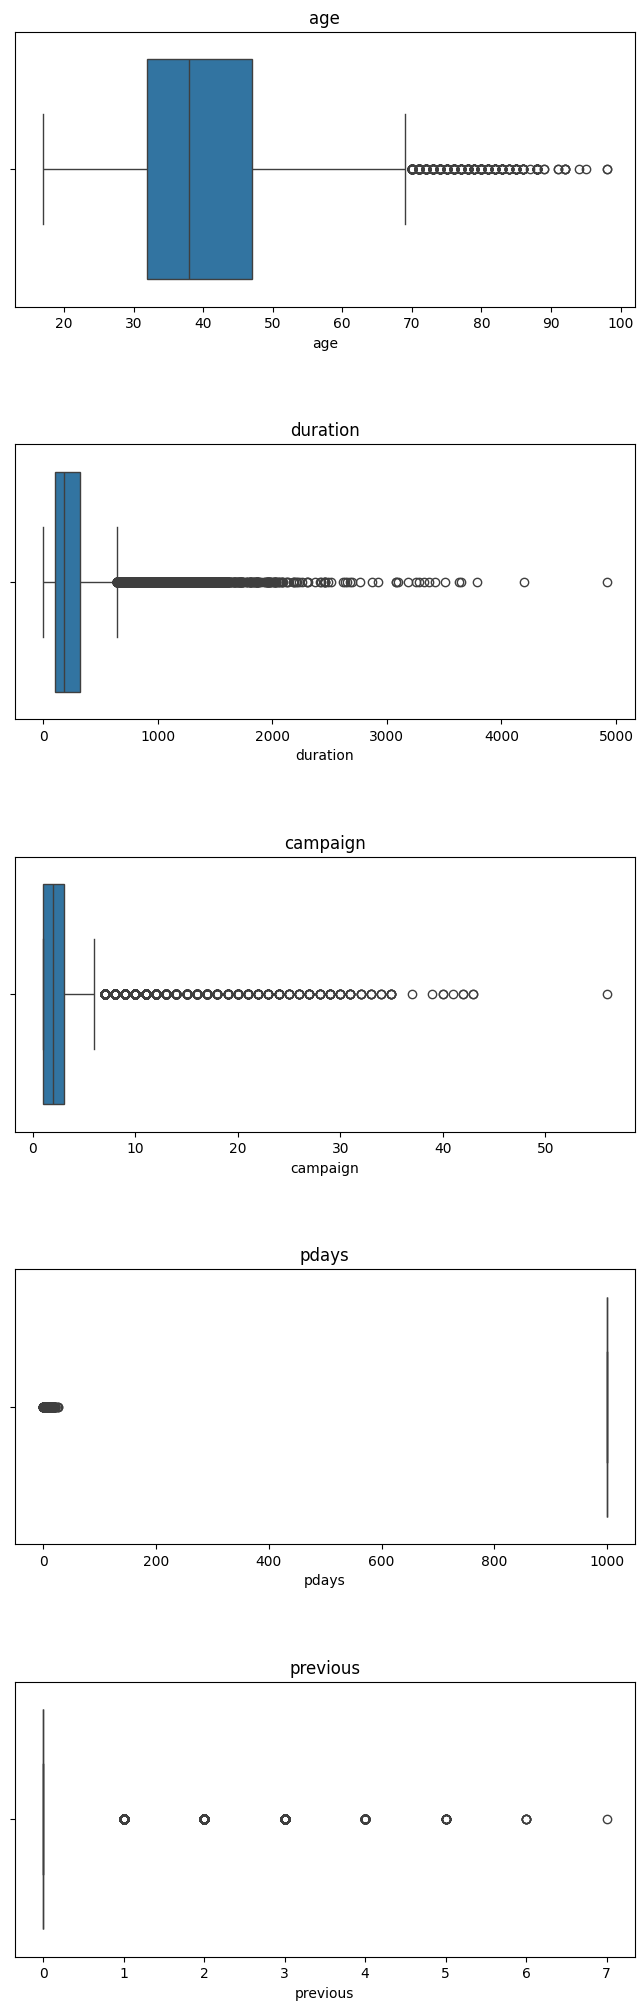

In [12]:
cols_num= ['age', 'duration', 'campaign','pdays','previous']

fig, ax = plt.subplots(nrows=len(cols_num), ncols=1, figsize=(8, 5 * len(cols_num)))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=df, ax=ax[i])
    ax[i].set_title(col)

plt.show()


Respecto a lo que vemos en boxplot: 

Edad: No hay valores que excedan los 100 años, por lo que podemos considerarlo dentro de un rango normal.
Duración: Hace referencia en segundos a la duración de la ultima llamada. El valor mas alto habla de una llamada d aproximadamente 83 minutos (5000 segundos) y existe un numero considerable de llamadas que tiene una duración de 2200-3000 minutos, por lo que podríamos entender que no es una llamada que se haga de manera rápida. 
Campaña refiere al numero de veces que se ha contactado al cliente: Hay valores que exceden los 30,40 e incluso un valor con mas de 50 contactos. Deberíamos llegar a entender cual es la duración de dicha campaña y cuantos se consideran un número de contactos excesivos. Tengamos en cuenta que si hablamos de una campaña anual, el valor mas alto entiende que se le ha contactado una media de 4 veces por mes. 

No obstante, no se observan outliers acusados o valores negativos que deban ser eliminados


Posibles errores en columnas categóricas

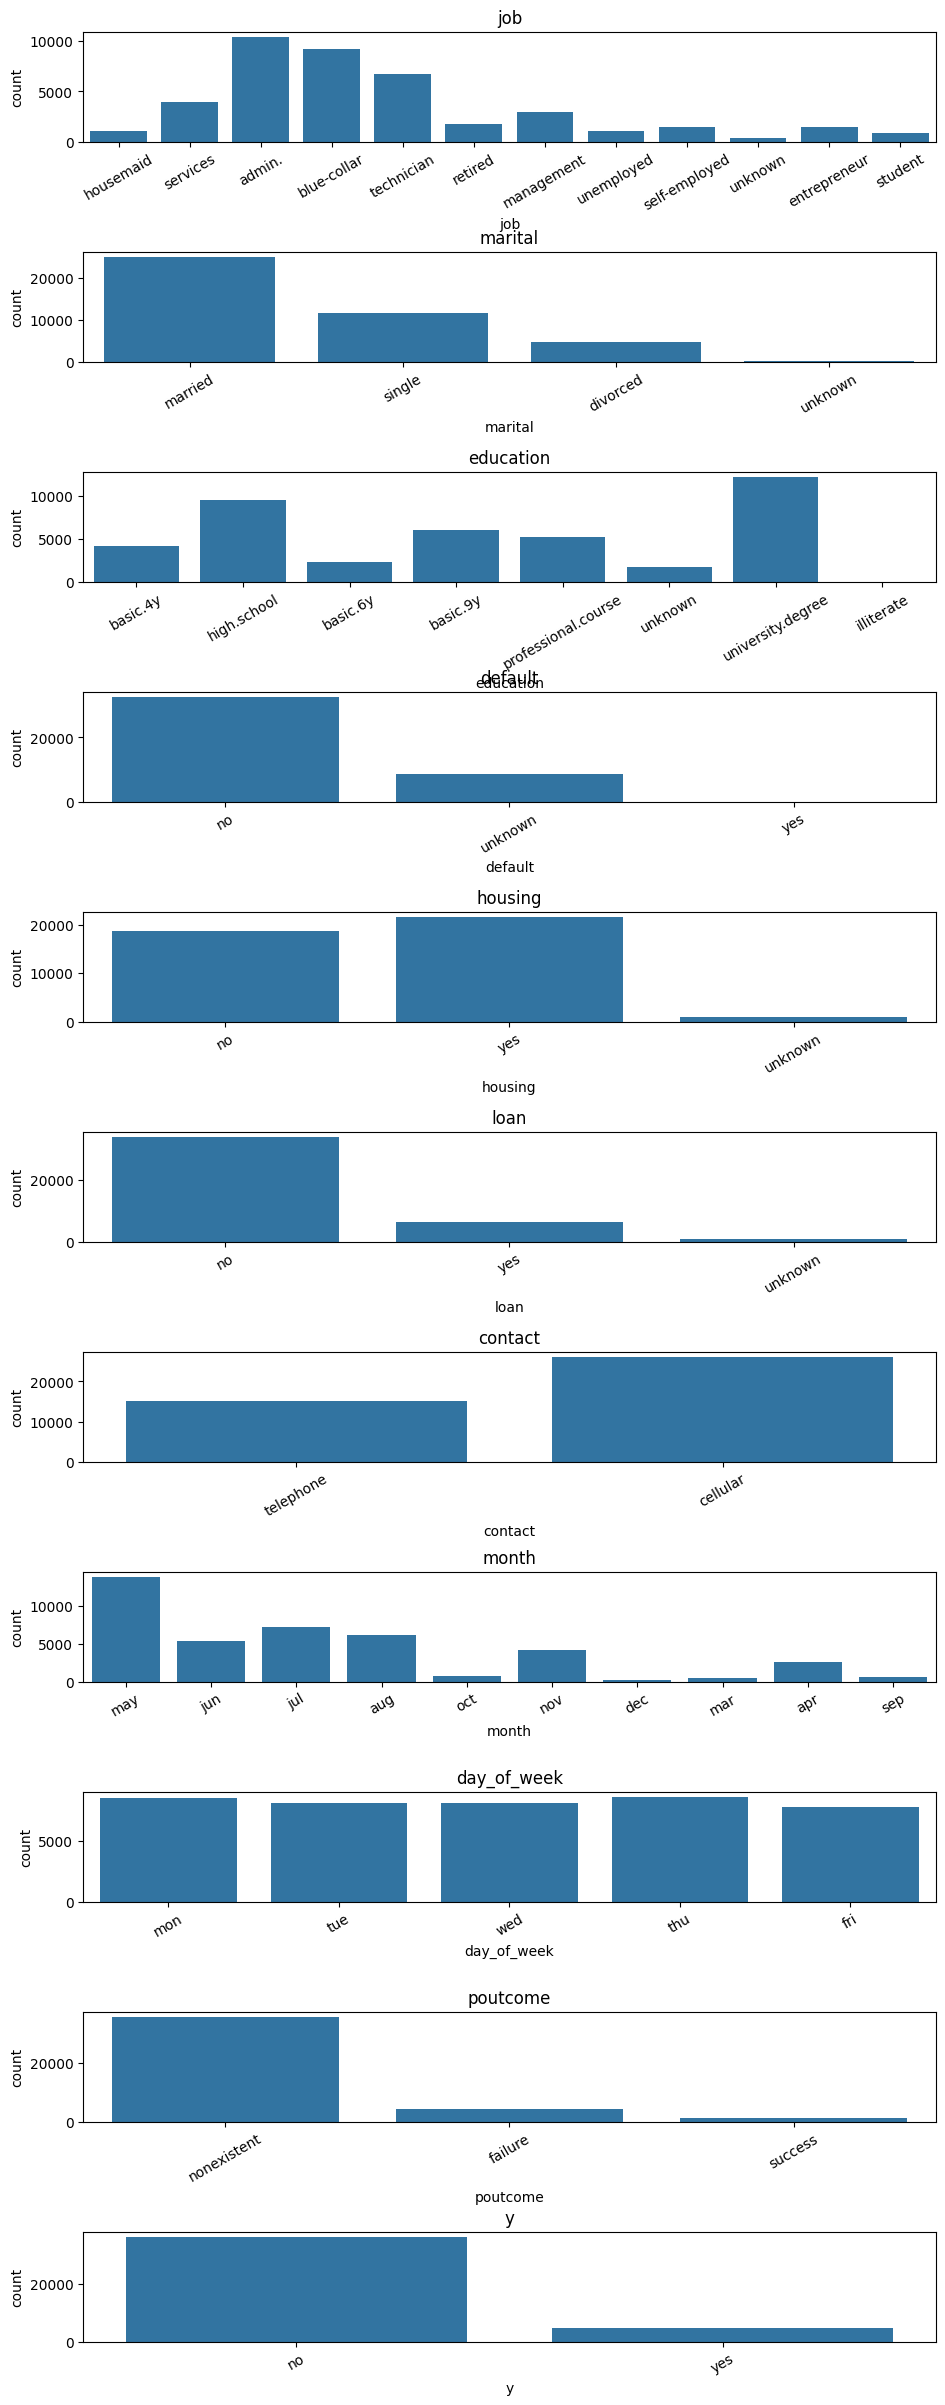

In [13]:

cols_cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
            'contact', 'month', 'day_of_week', 'poutcome', 'y']

fig, ax = plt.subplots(nrows=len(cols_cat), figsize=(11, 30))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(cols_cat):
    sns.countplot(x=col, data=df, ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)

if len(cols_cat) == 1:
    ax = [ax]

plt.show()


Comprobamos que no hay errores tipográficos (como admin y administrador) en ninguna de las variables

# Analisis exploratorio

Mirando los gráficos correspondientes a las columnas tanto categórica como no categórica que se han hecho durante la fase de la limpieza podemos determinar que todas las columnas con informacion relativa a la llamada que se han llevado a cabo: contact, month, day_of_the_week, duration, pdays, previous no aportan información relevante sobre el cliente, sino sobre la campaña de marketing. 

Luego vamos a eliminarlas.

In [14]:
df.drop(columns=['contact','month', 'day_of_week','duration', 'campaign','pdays','previous'],inplace=True)

df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [15]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Podríamos profundizar mucho más en el estudio si dispusiesemos de una columna que nos indicase de cuanto saldo disponían en su cuenta en el momento de aceptar/rechazar el préstamo. 

La ausencia de esta variable afecta mucho a la interpretación de los datos, limitándolo al número de prestamos que ha contratado (o no) sin tener en cuenta un valor tan fundamental como de cuanto dinero dispone

Variables Influyentes

In [16]:
#Creamos una nueva variable para facilitar el cálculo de la tasa de conversión
dicc_y = {'yes': 1, 'no': 0}
binario=df['y'].map(dicc_y) 
df['y_bin']=binario


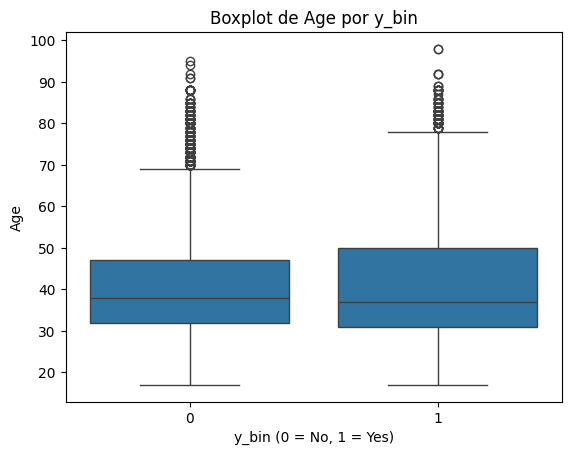

In [17]:
sns.boxplot(x='y_bin', y='age', data=df)
plt.title('Boxplot de Age por y_bin')
plt.xlabel('y_bin (0 = No, 1 = Yes)')
plt.ylabel('Age')
plt.show()

Podemos observar que hay una pequeña tendencia que muestra que son la gente que se halla cerca de la media de edad la que suele decir que no, y que gente incluso mas joven o mas mayor (además de los que se encuentran en ese rango) suelen decir que si.

No hay una diferencia significativa inicialmente.

Herramientas auxiliares : Calculadora de tasa de conversión

In [18]:
def calc_tasa_conversion(predictora, predecir, type='line', order=None):
   
    # Calcular la tasa de conversión
    grupo = df.groupby(predictora)[predecir].mean().mul(100).rename('tasa_conv').reset_index()

    plt.figure(figsize=(15, 10))
    if type == 'line':
        sns.lineplot(x=predictora, y='tasa_conv', data=grupo, palette="coolwarm")
    elif type == 'bar':
        sns.barplot(x=predictora, y='tasa_conv', data=grupo, order=order, palette="coolwarm")
    elif type == 'scatter':
        sns.scatterplot(x=predictora, y='tasa_conv', data=grupo, palette="coolwarm")
    else:
        raise ValueError("El parámetro 'type' debe ser 'line', 'bar' o 'scatter'.")

    # Personalización del gráfico
    plt.title(f'Tasa de Conversión por {predictora}')
    plt.xlabel(predictora)
    plt.ylabel('Tasa de Conversión (%)')
    plt.grid()
    plt.show()

    # Retornar los datos calculados
    return grupo

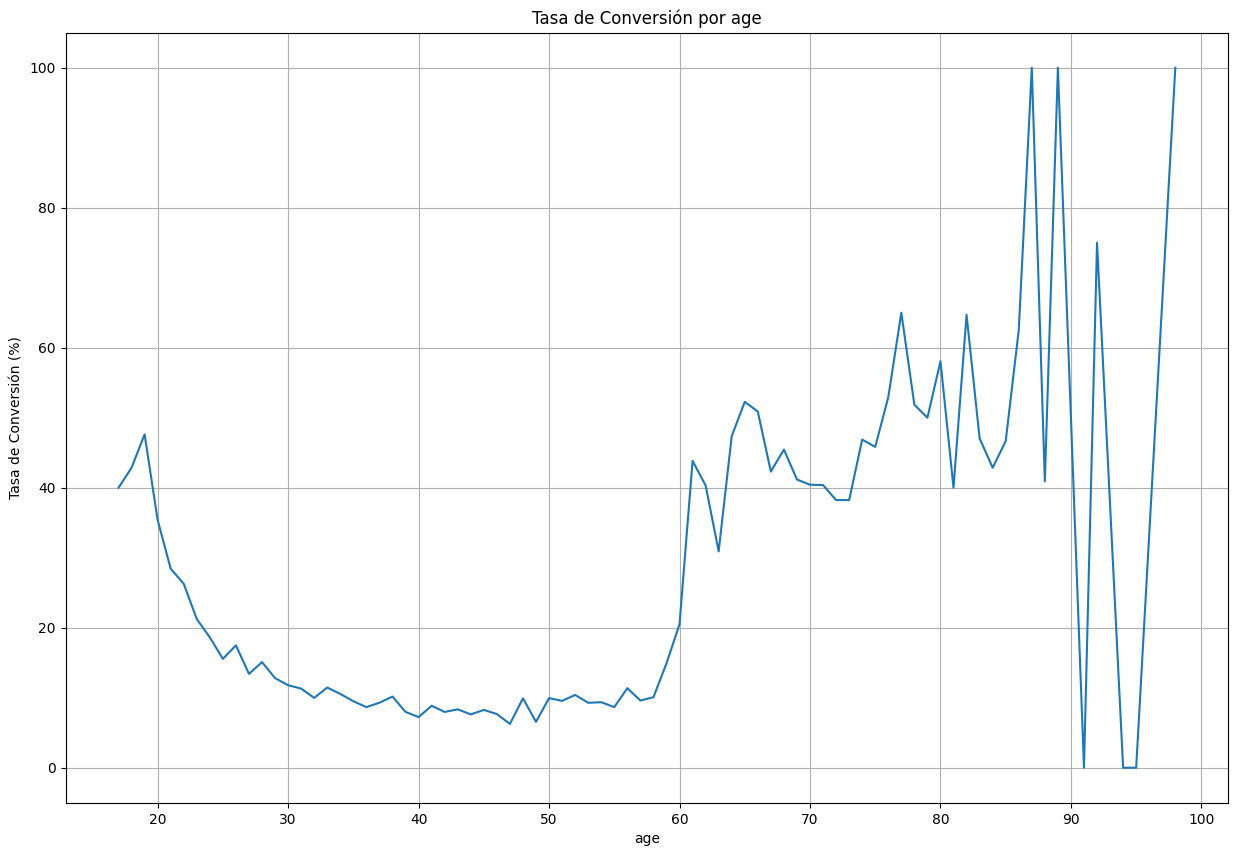

,age,tasa_conv
0,17,40.00
1,18,42.86
2,19,47.62
3,20,35.38
4,21,28.43
...,...,...
73,91,0.00
74,92,75.00
75,94,0.00
76,95,0.00


In [19]:
calc_tasa_conversion('age','y_bin')

Como se puede comprobar, entre los 17 y 20 años hay un porcentaje de 35-40% de personas que adquirió el producto. 
A partir de los 25 años hasta los 60, la tasa está por debajo del 20%.
A partir de los 60 años la tasa de dispara hasta un 40 %, acabando de subir en la franja de 80 años hasta un 60% con picos muy acusados en dterminados años entre los 80-90 de un 75 hasta un 100%

Vale la pena crear tres grupos de edad para poder tener una visión mas detallada de esta gráfica

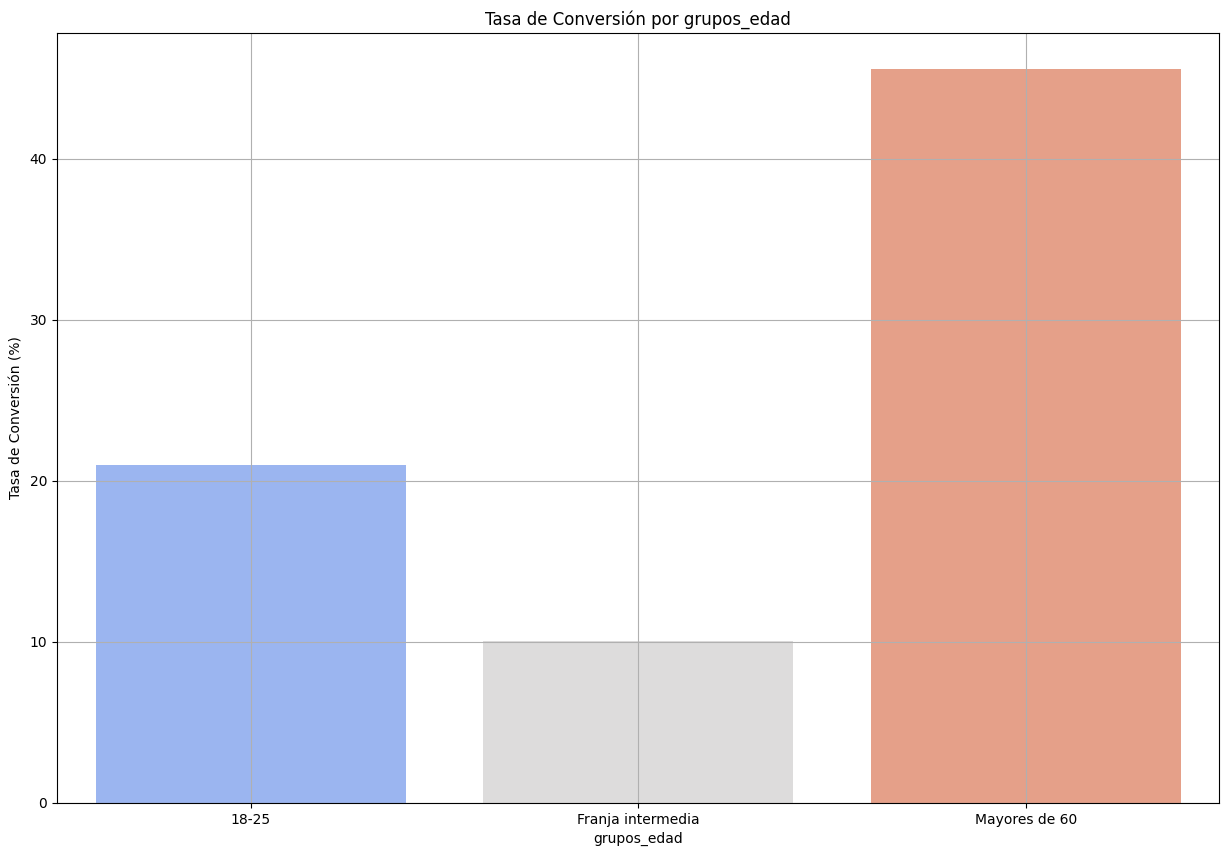

,grupos_edad,tasa_conv
0,18-25,20.96
1,Franja intermedia,10.04
2,Mayores de 60,45.54


In [20]:
df.loc[:, 'grupos_edad'] = "18-25"
df.loc[df['age'] > 60, 'grupos_edad'] = "Mayores de 60"
df.loc[(df['age'] > 25) & (df['age'] <= 60), 'grupos_edad'] = "Franja intermedia"


calc_tasa_conversion('grupos_edad','y_bin',type='bar')

Como se aprecia en la tabla, tenemos tasas de conversion de un 45% en los mayores de 60 años. 

Tenemos tres grupos bien definidos, que nos permiten centrar nuestros esfuerzos en futuras acciones. 

El siguiente paso lógico, habiendo trabajado con la variable edad, y convirtiéndola en tres grupos definidos, podríamos eliminarla.

In [21]:
df.drop(columns=['age'],inplace=True)

# Análisis de las variables categóricas

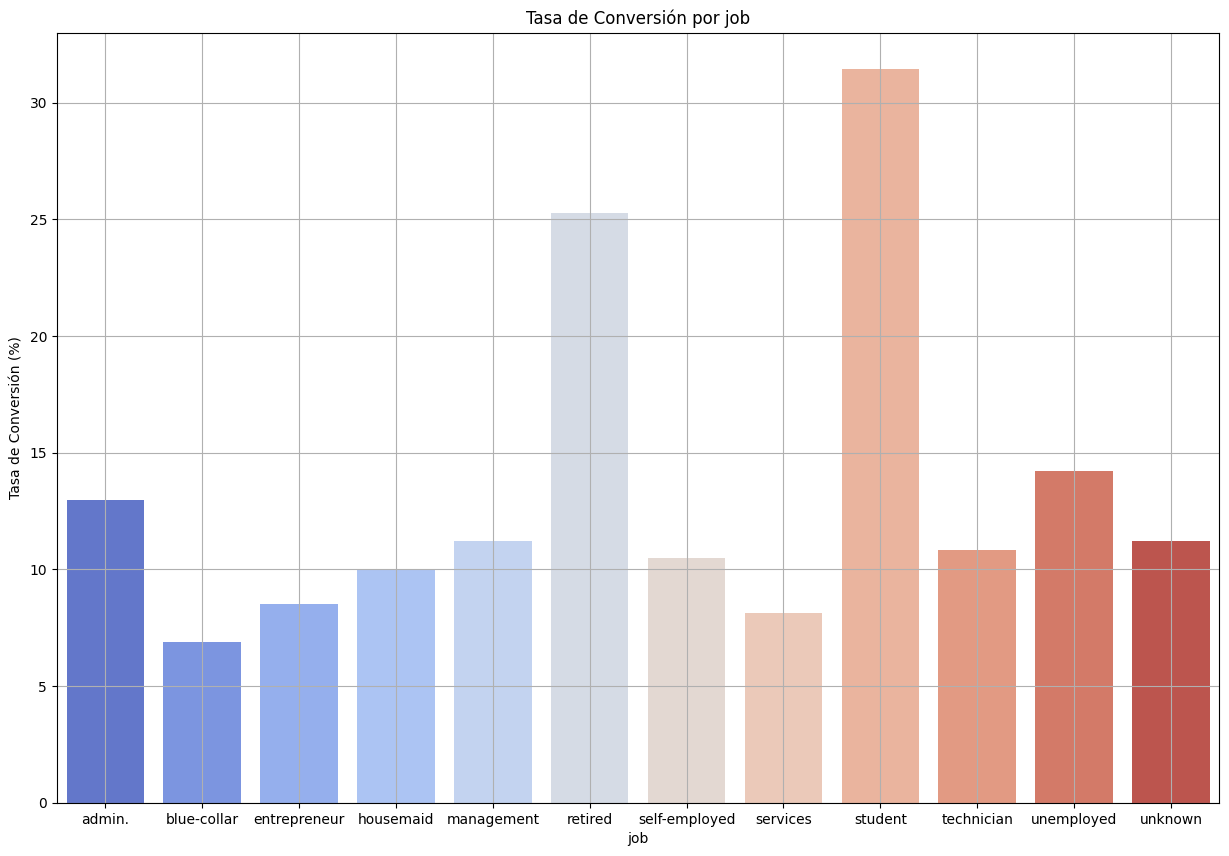

,job,tasa_conv
0,admin.,12.97
1,blue-collar,6.90
2,entrepreneur,8.52
3,housemaid,10.00
4,management,11.22
5,retired,25.26
6,self-employed,10.49
7,services,8.14
8,student,31.43
9,technician,10.83


In [22]:
#analizemos la variable JOB
calc_tasa_conversion('job','y_bin',type='bar')

Podemos comprobar que estudiantes y jubilados son las personas mas proclives a contratar el seguro. 

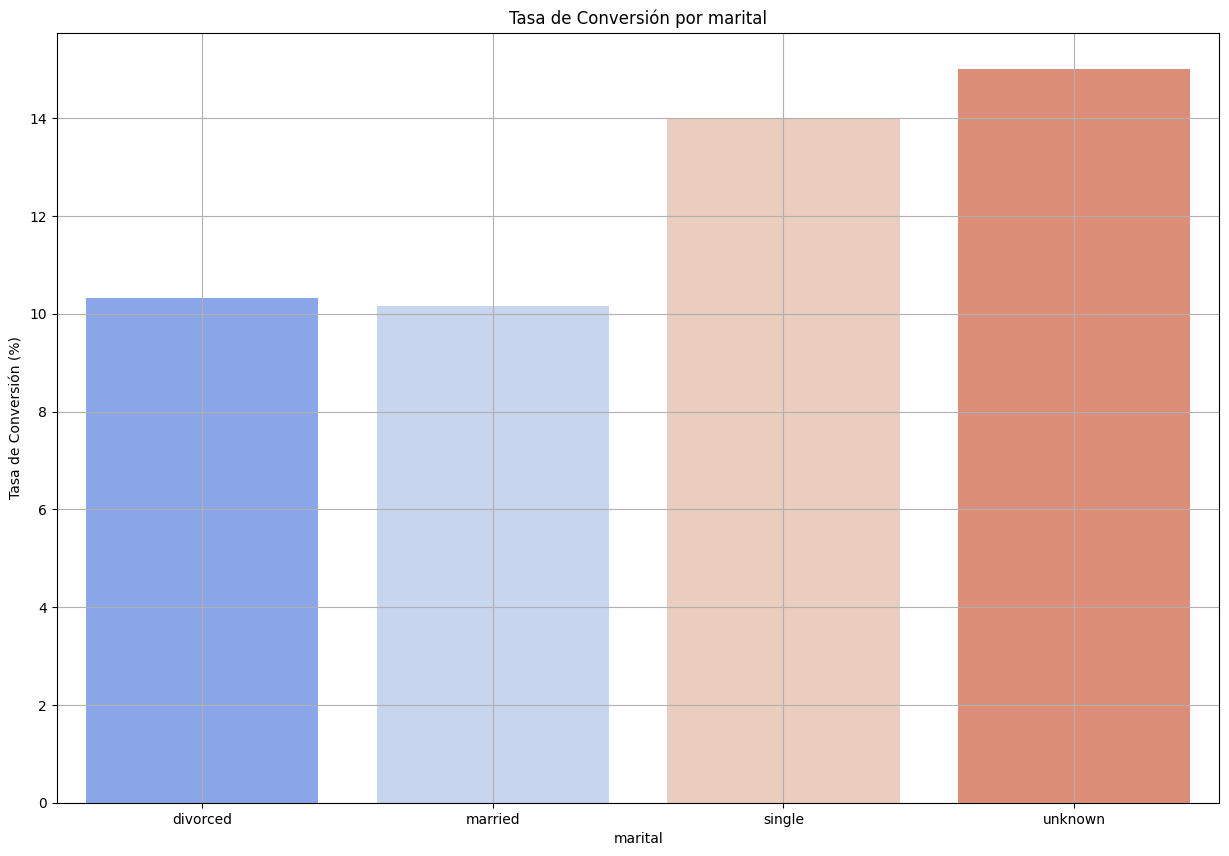

,marital,tasa_conv
0,divorced,10.32
1,married,10.16
2,single,14.01
3,unknown,15.00


In [23]:
#analizemos la variable JOB
calc_tasa_conversion('marital','y_bin',type='bar')

Tenemos una alta tasa de valores desconocidos, que podrían responden a personas que simplemente no han querido contestar a la pregunta en la llamada. Con los datos que disponemos podemos determinar que a pesar de que hay poca diferencia, la gente soltera es mas proclive a contratar el producto.

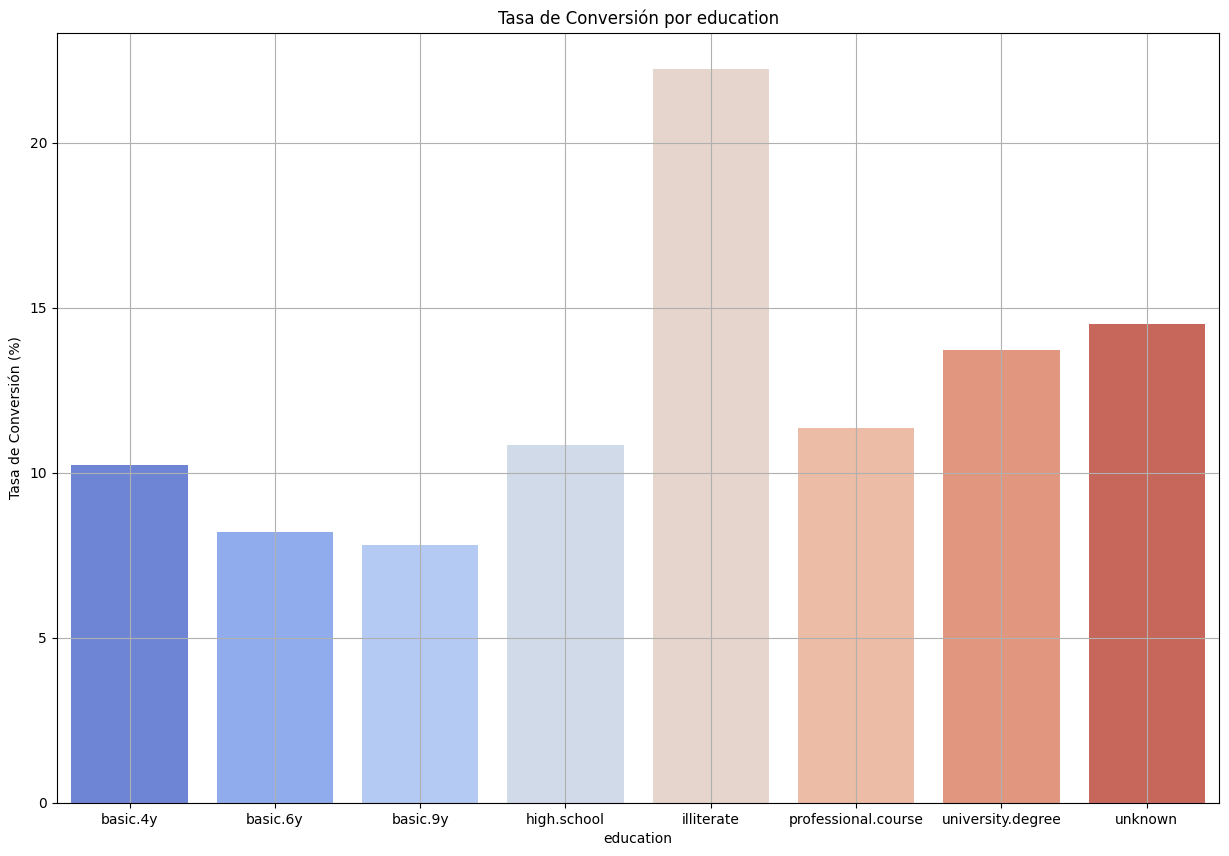

,education,tasa_conv
0,basic.4y,10.25
1,basic.6y,8.21
2,basic.9y,7.82
3,high.school,10.84
4,illiterate,22.22
5,professional.course,11.35
6,university.degree,13.72
7,unknown,14.51


In [24]:
calc_tasa_conversion('education','y_bin',type='bar')

El perfil de persona que contrata el producto es alguien sin educación. De nuevo hay valores desconocidos que tienen un porcentaje preminente. Otros segmentos en los que fijarse sería el universitario(que coincidiría con uno de los grupos de edad) y profesionales.

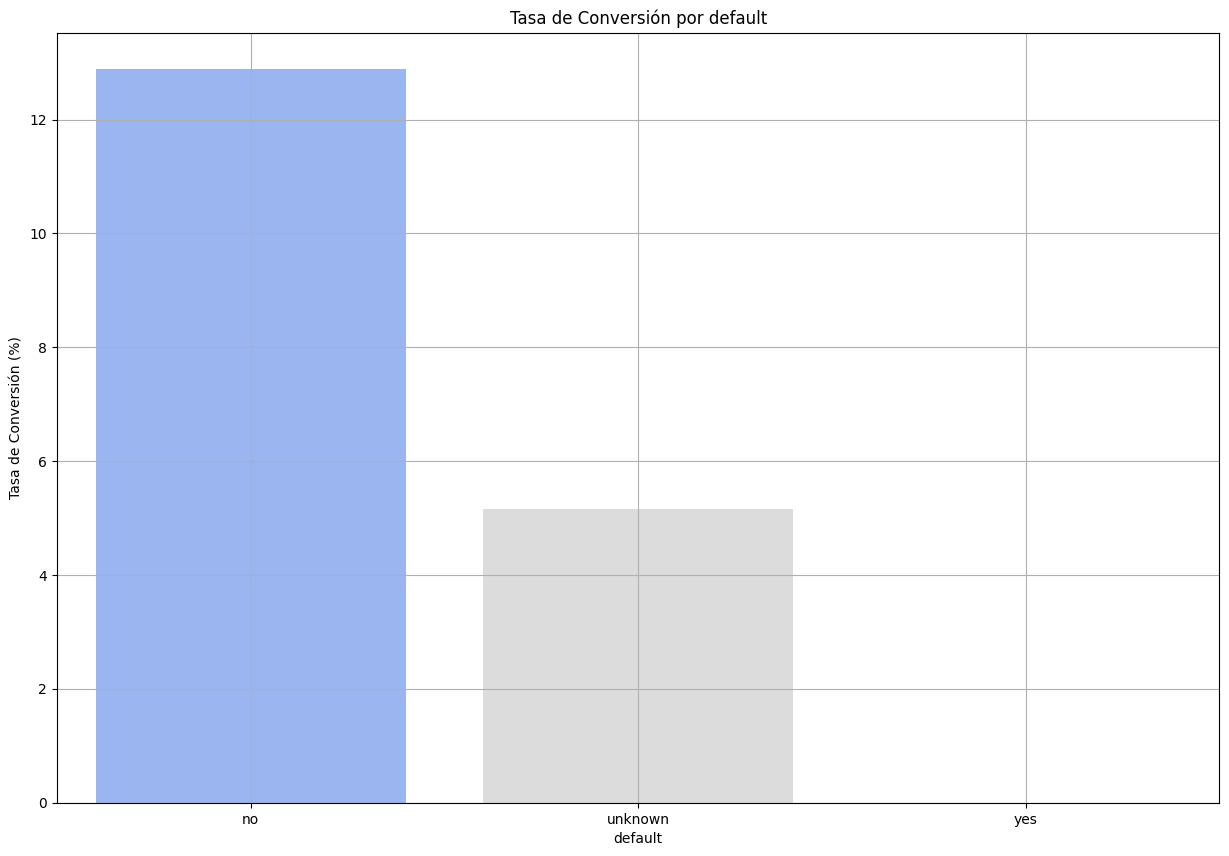

,default,tasa_conv
0,no,12.88
1,unknown,5.15
2,yes,0.00


In [25]:
calc_tasa_conversion('default','y_bin',type='bar')

Evidentemente, la gente mas propensa a contratar nuestro producto es aquella que ya paga a tiempo los prestamos concedidos por el banco, con un evidente 0% en gente que no paga a tiempo y una tasa de unknown relevante

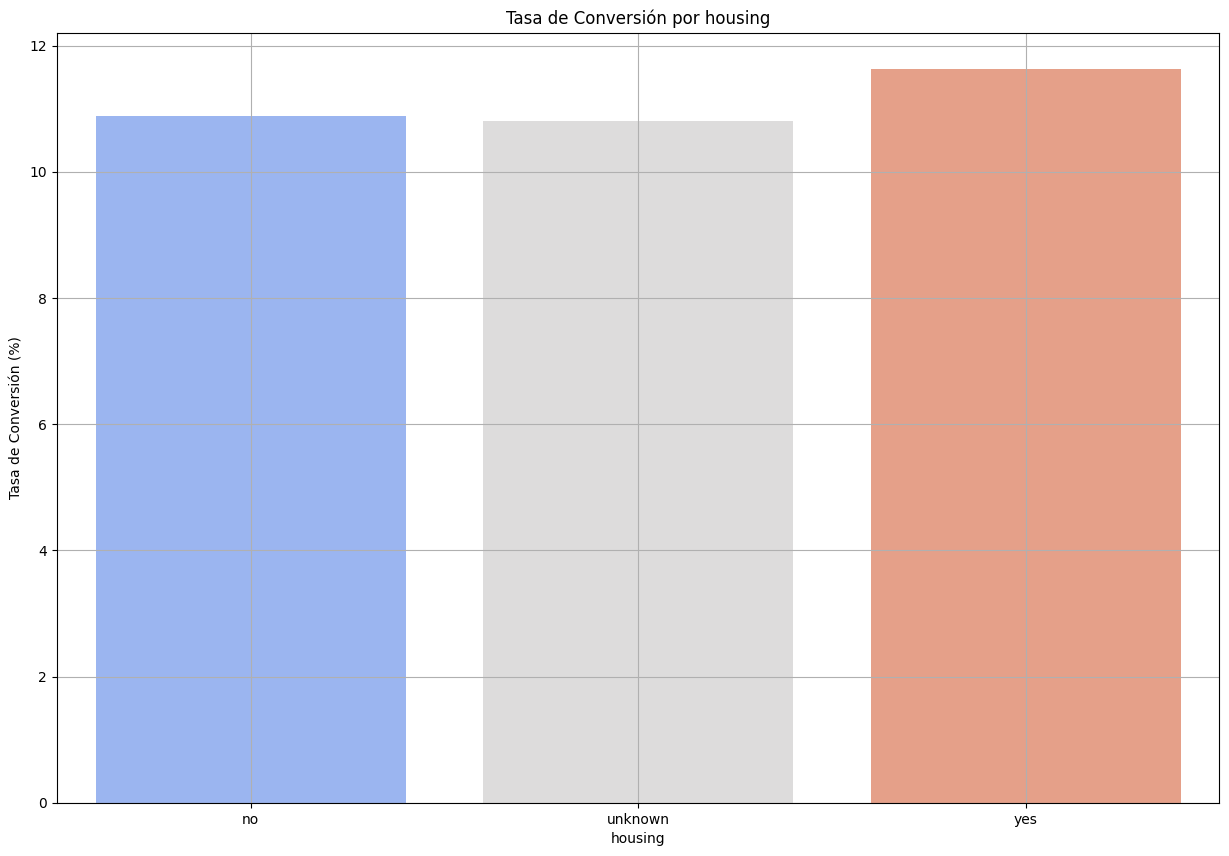

,housing,tasa_conv
0,no,10.88
1,unknown,10.81
2,yes,11.62


In [26]:
calc_tasa_conversion('housing','y_bin',type='bar')

No hay diferencias significativas entre aquellos que disponen de credito hipotecario de la casa y los que no

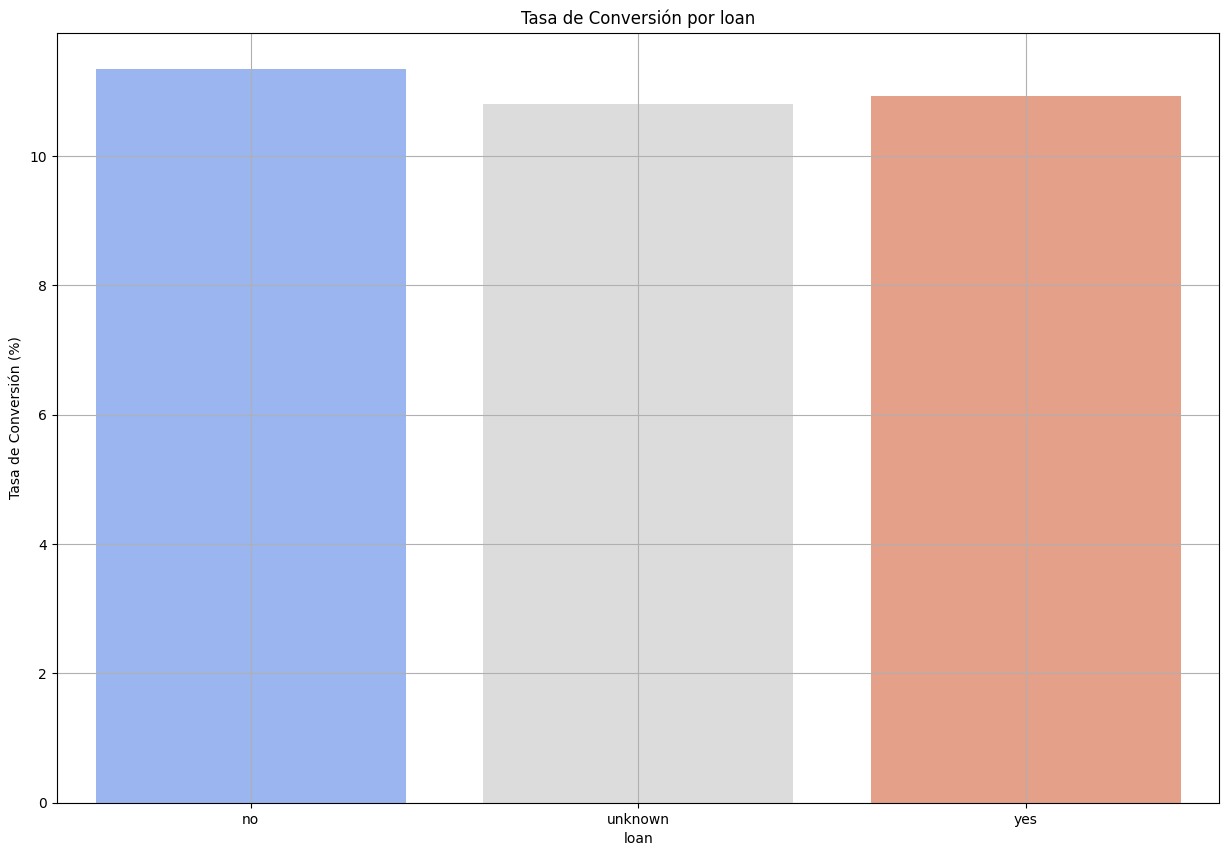

,loan,tasa_conv
0,no,11.34
1,unknown,10.81
2,yes,10.93


In [27]:
calc_tasa_conversion('loan','y_bin',type='bar')

No hay diferencias significativas entre aquellos que disponen de prestamo personal y los que no

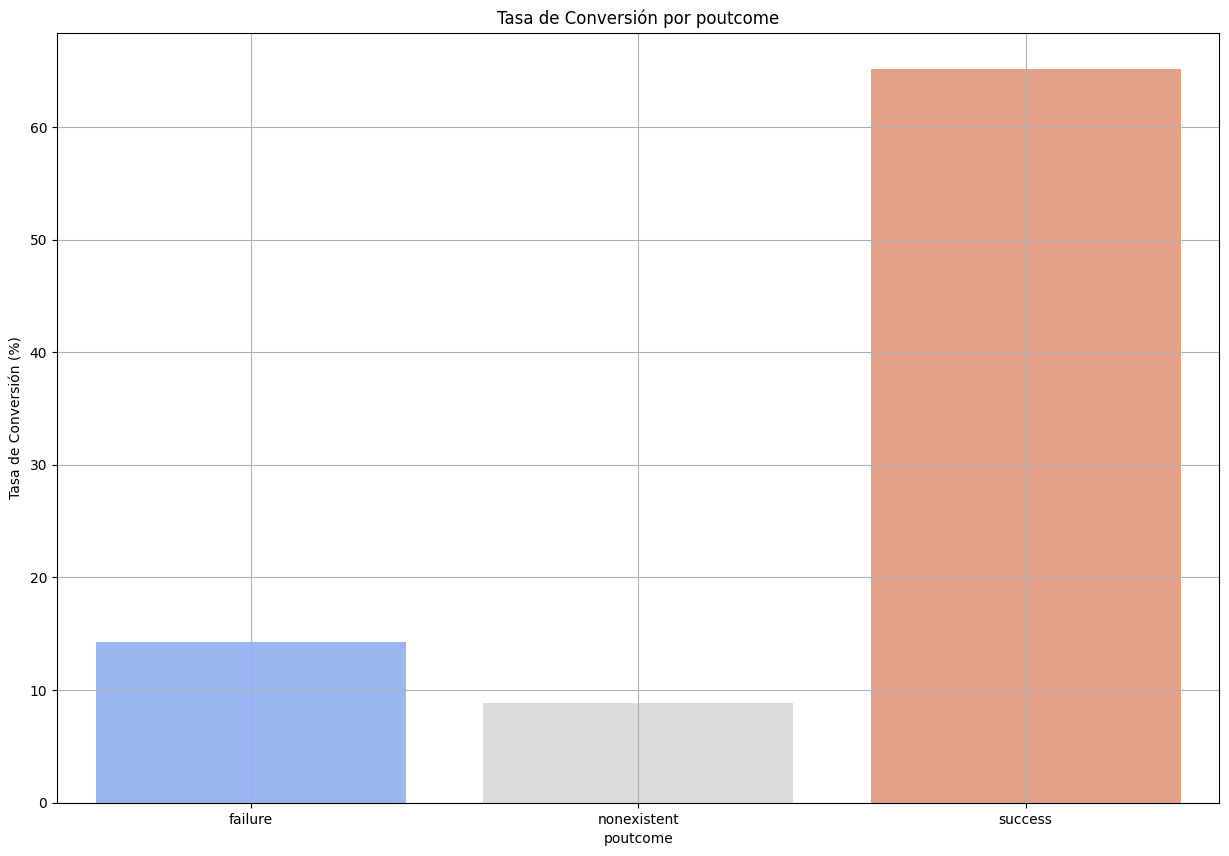

,poutcome,tasa_conv
0,failure,14.23
1,nonexistent,8.83
2,success,65.11


In [28]:
calc_tasa_conversion('poutcome','y_bin',type='bar')

Aquí si que hay un claro indicador que muestra que si el cliente adquirió un producto en una campaña anterior, es probable (65%) que contrate un nuevo producto con el banco.


Por lo tanto podemos concluir: 

1- Que la variable poutcome tiene una tasa de conversion muy alta

2- Que es principalmente contratado por estudiantes o personas jubiladas

3- Que los clientes que pagan sus créditos son los más proclives a contratar otro 

4 - Que el perfil tiende a ajustarse a alguien soltero e illiterate

# Análisis bivariado con la tasa de conversión

De misma manera, habiendo probado ser útil, vamos a crear una "calculadora" que nos muestre el gráfico de la tasa de conversión con las dos variables que le indiquemos. 

In [36]:
def calc2_tasa_conversion(col_list, orden=None):
    tc = df.groupby(col_list)['y_bin'].mean().to_frame().reset_index()
    plt.figure(figsize=(13, 7))
    ax = sns.pointplot(x='y_bin', y=col_list[0], hue=col_list[1], data=tc, dodge=True)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    plt.title(f'Tasa de conversión para {col_list[0]} y {col_list[1]}')
    plt.xlabel('Tasa de conversión (%)')
    plt.xlim((0, 1))
    plt.show()

    

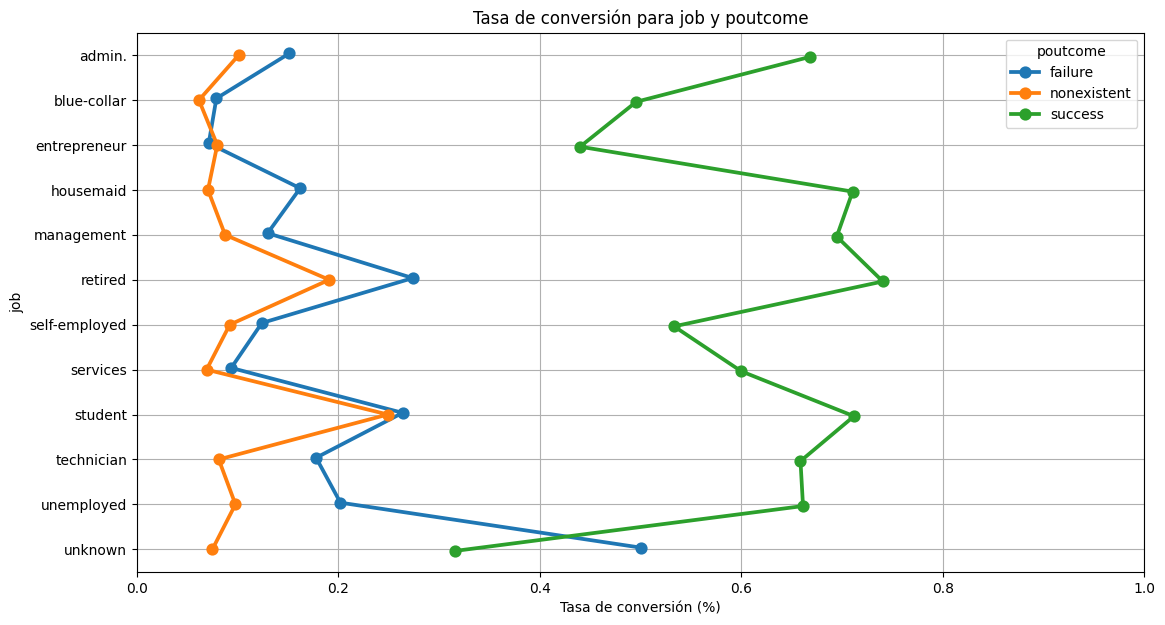

In [37]:
calc2_tasa_conversion(['job','poutcome'])

Es interesante poder ver como se distribuyen los valores de todos aquellos que ya contrataron un producto con tasas significativas en amas de casa, management y gente jubilada, principalmente, seguidos de cerca por los estudiantes

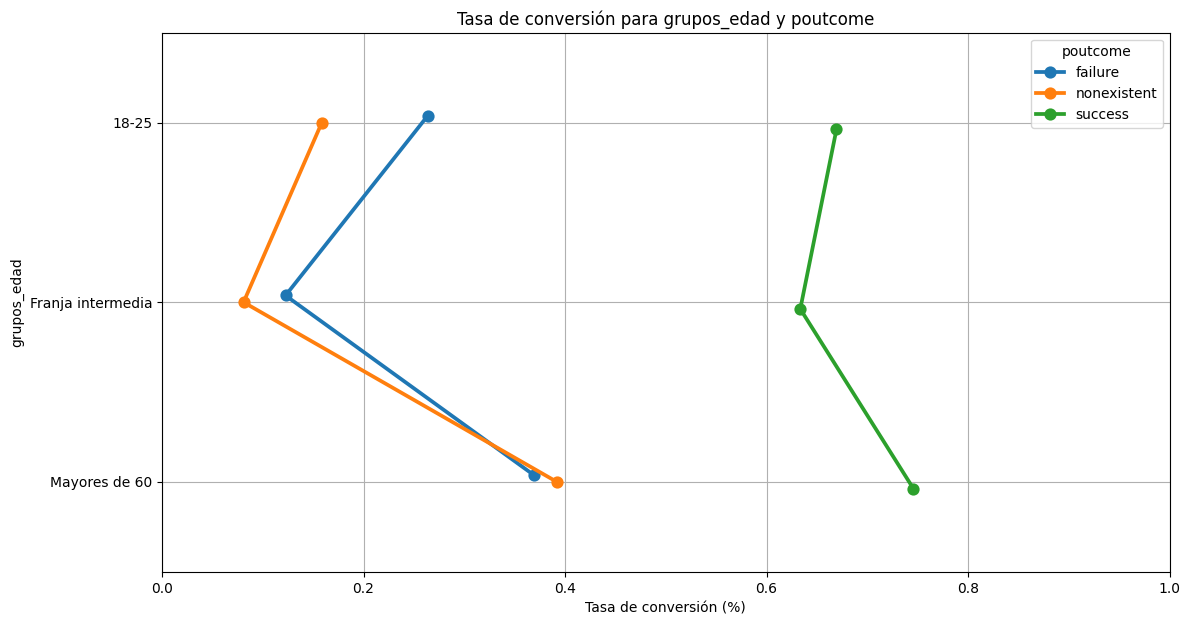

In [40]:
calc2_tasa_conversion(['grupos_edad','poutcome'])

Como se muestra en la gráfica, los dos grupos correspondientes a gente por encima de los 60 y por debajo de los 20 son mas proclives a contratar el producto

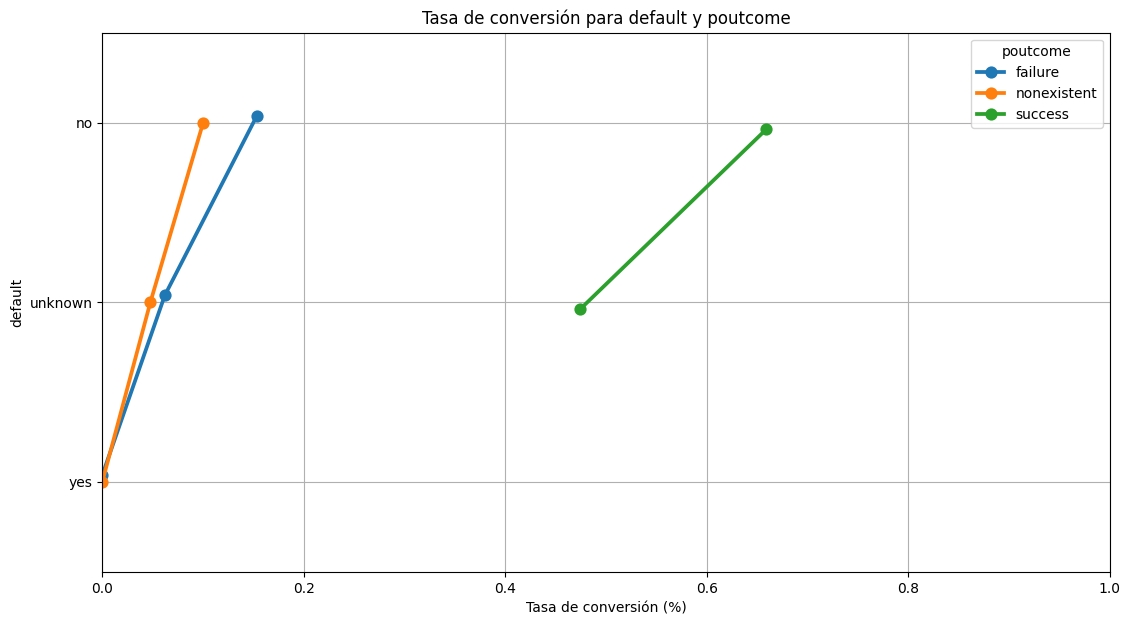

In [42]:
calc2_tasa_conversion(['default','poutcome'])

Tal y como habíamos indicado existe una gran posibilidad de que aquellos que tienen un crédito y lo pagan y han sido contactado anteriormente (y contrataron un producto) contraten otro producto

Concluyendo, podemos determinar, que: 

- El cliente debe haber sido ya contactado en campañas anteriores

- Desempleado, estudiante o jubilado son los mas marcados

- Edades entre 18-25 o 60 para arriba.

- Idealmente que no tenga ningun crédito o que no tenga retrasos en el pago de creditos concedidos


# Construir un modelo de regresion lineal

In [47]:
# Separamos las variables independientes de la dependiente

#Necesitamos factorizar para convertir en numérico las variables categóricas
df["job"] = pd.factorize(df["job"])[0]
df["marital"] = pd.factorize(df["marital"])[0]
df["education"] = pd.factorize(df["education"])[0]
df["default"] = pd.factorize(df["default"])[0]
df["housing"] = pd.factorize(df["housing"])[0]
df["loan"] = pd.factorize(df["loan"])[0]
df["poutcome"] = pd.factorize(df["poutcome"])[0]
df["grupos_edad"] = pd.factorize(df["poutcome"])[0]

X = df.drop(['y','y_bin'], axis=1)
y = df['y_bin']



In [50]:
import statsmodels.api as sm

# Agregar constante
X = sm.add_constant(X)

# Ajustar modelo
model = sm.OLS(y, X).fit()

# Resumen del modelo
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  y_bin   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     611.7
Date:                Wed, 22 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:05:32   Log-Likelihood:                -7635.9
No. Observations:               41176   AIC:                         1.530e+04
Df Residuals:                   41163   BIC:                         1.541e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.3902      1.043     -1.

Como se puede comprobar podemos extraer las siguientes conclusiones: 

- Las variables como job, education, default, poutcome, emp.var.rate, y cons.price.idx parecen tener un impacto significativo en y_bin, según su respectivo P-value.
- El intercepto es -1.3902, pero tiene una significancia p de 0.182, lo que indica que no es estadísticamente significativo.

## Validacion de asunciones

### Linealidad

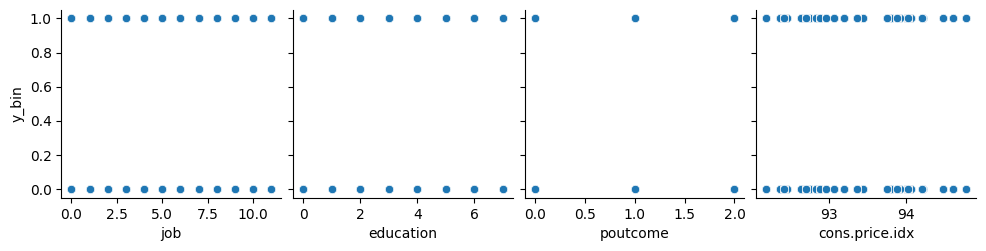

In [51]:
sns.pairplot(df, y_vars='y_bin', x_vars=['job', 'education', 'poutcome', 'cons.price.idx'])
plt.show()

### Homocedasticidad

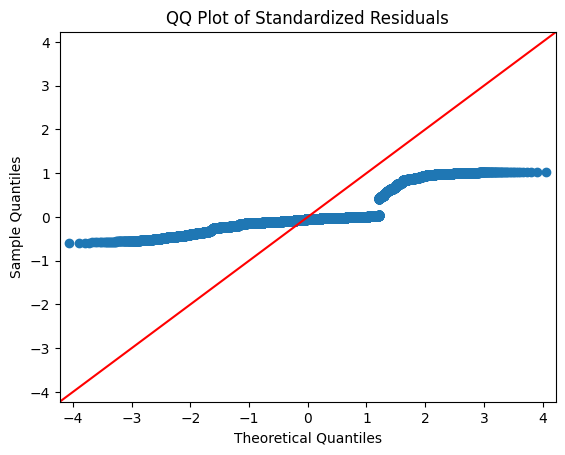

In [52]:
# Residuos estandarizados
residuals = model.resid
sm.qqplot(residuals, line ='45')
plt.title('QQ Plot of Standardized Residuals')
plt.show()

Se puede ver como los residuos se mueve en valores cercanos a 0. 

In [56]:
# Prueba de normalidad
import scipy.stats as stats
_, p_value = stats.shapiro(residuals)
print(f"P-value: {p_value}")

P-value: 4.3364535880143596e-123


Dado que el valor se acerca a 0, los residuos entran dentro del rango normal

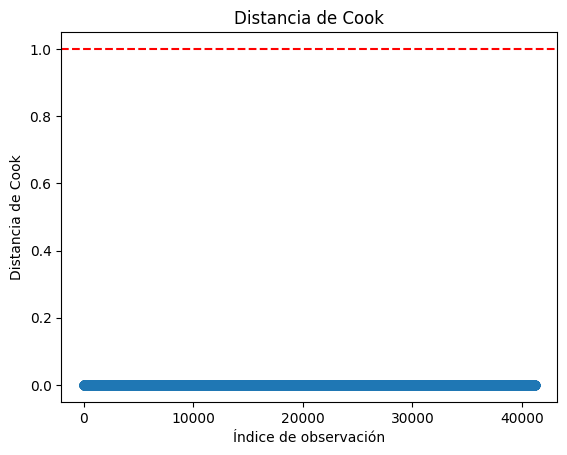

In [58]:
from statsmodels.stats.outliers_influence import OLSInfluence

# Calcular la influencia
influence = OLSInfluence(model)
cook_d = influence.cooks_distance[0]

plt.scatter(range(len(cook_d)), cook_d)
plt.axhline(1, color='r', linestyle='--')  # Límite crítico
plt.xlabel('Índice de observación')
plt.ylabel('Distancia de Cook')
plt.title('Distancia de Cook')
plt.show()

Podemos comprobar que no hay valores que se vayan por encima de 1. Por lo que la distancia de Cook nos cerciora que el data con el que trabajamos está dentro de lo aceptable

# Dividimos el data set entre train y test

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Selección de características.

In [60]:
X_train.corr()

,const,job,marital,education,default,housing,loan,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,grupos_edad
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job,NaN,1.00,-0.01,0.17,-0.02,0.01,-0.01,0.05,-0.08,-0.04,0.02,-0.07,-0.08,0.05
marital,NaN,-0.01,1.00,0.06,-0.11,0.01,-0.00,0.03,-0.05,-0.03,-0.05,-0.05,-0.05,0.03
education,NaN,0.17,0.06,1.00,-0.14,0.02,-0.00,0.03,-0.03,-0.08,0.08,-0.02,-0.03,0.03
default,NaN,-0.02,-0.11,-0.14,1.00,-0.01,0.00,-0.11,0.20,0.17,0.02,0.19,0.19,-0.11
housing,NaN,0.01,0.01,0.02,-0.01,1.00,0.29,0.02,-0.05,-0.07,-0.03,-0.05,-0.04,0.02
loan,NaN,-0.01,-0.00,-0.00,0.00,0.29,1.00,0.00,0.01,0.01,-0.01,0.00,0.01,0.00
poutcome,NaN,0.05,0.03,0.03,-0.11,0.02,0.00,1.00,-0.46,-0.26,-0.04,-0.48,-0.51,1.00
emp.var.rate,NaN,-0.08,-0.05,-0.03,0.20,-0.05,0.01,-0.46,1.00,0.77,0.20,0.97,0.91,-0.46
cons.price.idx,NaN,-0.04,-0.03,-0.08,0.17,-0.07,0.01,-0.26,0.77,1.00,0.06,0.69,0.52,-0.26


Numéricas: 

Las variables emp.var.rate, euribor3m y nr.employed tienen correlaciones muy altas.

Las variables poutcome, default y grupos_edad muestran correlaciones moderadas

Categóricas: 

Muestran una correlación relativamente baja (< 0.2) entre sí y con otras variables.

Housing y loan, tienen correlaciones cercanas a 0, lo que sugiere una mínima relación entre ellas y otras variables.

In [ ]:
vif = pd.Series(
    [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
    index=X_train.columns
)

vif

const            523105.73
job                   1.04
marital               1.02
education             1.07
default               1.07
housing               1.10
loan                  1.09
poutcome               inf
emp.var.rate         33.09
cons.price.idx        6.31
cons.conf.idx         2.61
euribor3m            64.10
nr.employed          31.14
grupos_edad            inf
dtype: float64

### Mapa de correlaciones

<Axes: >

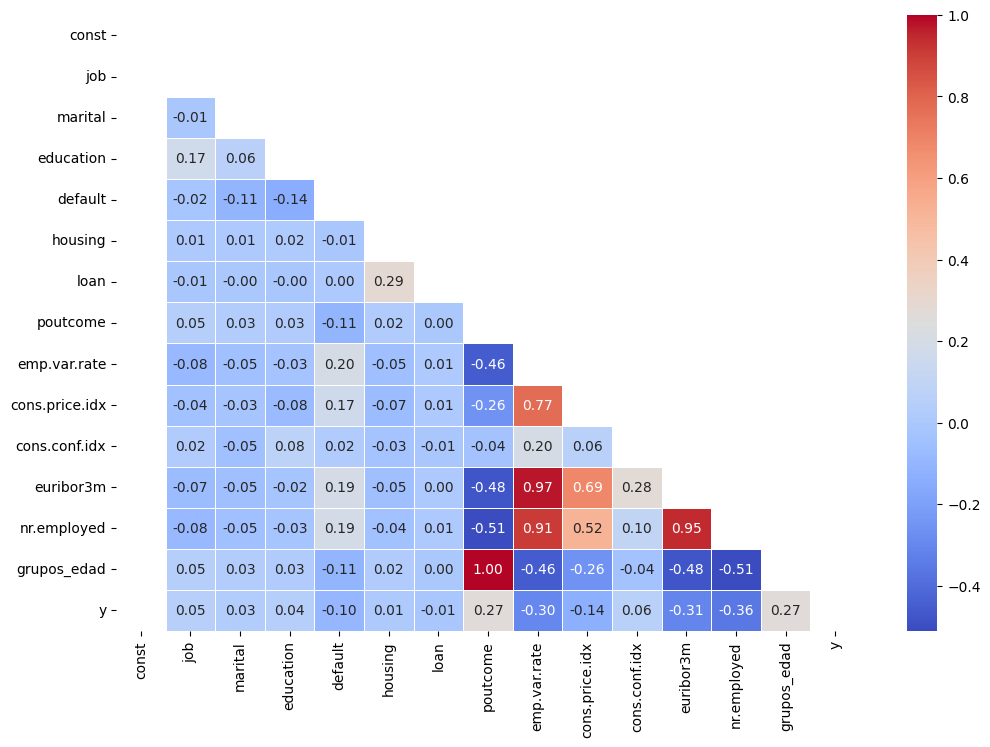

In [64]:
X_corr = X_train.copy()
X_corr['y'] = y_train
corr = X_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

Identificar las variables binarias

In [65]:
binary_cols = X_train[(X_train == 0)|(X_train == 1)].dropna(axis=1).columns
binary_cols

Index(['const'], dtype='object')

In [66]:
# selecciono las columnas que no son binarias
X_train_num = X_train.drop(binary_cols, axis=1)
X_test_num = X_test.drop(binary_cols, axis=1)

Instancio la clase del escalador y lo ajusto con los datos de entrenamiento

In [67]:
scaler = MinMaxScaler().fit(X_train_num)

Transformamos los datos numericos con el escalador ajustado

In [68]:
X_train_num_sc = scaler.transform(X_train_num)
X_test_num_sc = scaler.transform(X_test_num)

In [69]:
X_train_sc = pd.concat([pd.DataFrame(X_train_num_sc, columns = X_train_num.columns), X_train[binary_cols].reset_index(drop=True)], axis=1)
X_test_sc = pd.concat([pd.DataFrame(X_test_num_sc, columns = X_test_num.columns), X_test[binary_cols].reset_index(drop=True)], axis=1)

from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=20)  # Selecciona las 20 mejores características
X_train_sc_reduced = selector.fit_transform(X_train_sc, y_train)
X_test_sc_reduced = selector.transform(X_test_sc)

In [70]:
X_train_sc

,job,marital,education,default,housing,loan,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,grupos_edad,const
0,0.91,0.00,0.29,0.00,0.50,0.50,0.00,1.00,0.67,0.34,0.98,1.00,0.00,1.00
1,0.18,0.33,0.86,0.00,0.00,0.00,0.00,1.00,0.88,0.38,0.96,1.00,0.00,1.00
2,0.18,0.33,0.86,0.00,0.00,0.00,0.00,1.00,0.48,0.62,0.98,1.00,0.00,1.00
3,0.18,0.33,0.86,0.00,0.00,0.00,0.00,0.94,0.70,0.60,0.96,0.86,0.00,1.00
4,0.27,0.33,0.14,0.50,0.00,0.00,0.00,0.33,0.27,0.19,0.15,0.51,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32935,0.27,0.00,0.43,0.00,0.00,0.50,0.00,0.94,0.70,0.60,0.96,0.86,0.00,1.00
32936,0.18,0.00,0.43,0.00,0.50,0.00,0.00,1.00,0.88,0.38,0.98,1.00,0.00,1.00
32937,0.45,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.09,1.00,0.03,0.20,0.50,1.00
32938,0.55,0.00,0.86,0.00,0.50,0.00,0.00,0.94,0.70,0.60,0.96,0.86,0.00,1.00


# Selección del algoritmo regresivo

In [71]:
from lazypredict.Supervised import LazyClassifier

# Crear la instancia de LazyClassifier excluyendo los modelos no deseados
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Ajustar el modelo a los datos de entrenamiento y realizar predicciones
models, predictions = clf.fit(X_train_sc, X_test_sc, y_train, y_test)

# Mostrar los resultados
print(models)


 97%|█████████▋| 31/32 [00:32<00:02,  2.08s/it]

[LightGBM] [Info] Number of positive: 3668, number of negative: 29272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 32940, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111354 -> initscore=-2.076985
[LightGBM] [Info] Start training from score -2.076985


100%|██████████| 32/32 [00:32<00:00,  1.02s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.71               0.71     0.71      0.76   
BernoulliNB                        0.77               0.70     0.70      0.80   
GaussianNB                         0.81               0.69     0.69      0.83   
LinearDiscriminantAnalysis         0.88               0.64     0.64      0.87   
RandomForestClassifier             0.88               0.62     0.62      0.87   
DecisionTreeClassifier             0.87               0.62     0.62      0.86   
BaggingClassifier                  0.88               0.62     0.62      0.86   
ExtraTreesClassifier               0.88               0.61     0.61      0.86   
KNeighborsClassifier               0.89               0.61     0.61      0.87   
Perceptron                         0.83               0.61     0.61      0.84   
ExtraTreeClassifier         

# Búsqueda de hiperparámetros

In [72]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

# Instanciamos el estimador
estimator = LGBMClassifier()

# Definimos el espacio de búsqueda de los hp
param_dist = {'n_estimators':[10, 50, 100, 250], 'max_depth':np.arange(10, 100, 10)}

random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_dist,
    n_iter=5,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy',  # Cambia la métrica si es necesario
    verbose=2,
    cv=5
)

# Ajustamos el modelo
random_search.fit(X_train_sc, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[LightGBM] [Info] Number of positive: 2935, number of negative: 23417[LightGBM] [Info] Number of positive: 2935, number of negative: 23417

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 26352, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111377 -> initscore=-2.076755
[LightGBM] [Info] Start training from score -2.076755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 26352, number of used features: 13
[LightGBM] [Info] [bin

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                                        'n_estimators': [10, 50, 100, 250]},
                   random_state=42, scoring='accuracy', verbose=2)

In [73]:

# Imprimimos los mejores parámetros y la mejor puntuación
print("Mejores parámetros:", random_search.best_params_)
print("Mejor puntuación:", random_search.best_score_)

Mejores parámetros: {'n_estimators': 50, 'max_depth': np.int64(40)}
Mejor puntuación: 0.9010018214936247


Modelo optimizado

In [74]:
estimator_opt = LGBMClassifier(n_estimators=50,max_depth=40)

random_search.fit(X_train_sc, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Info] Number of positive: 2935, number of negative: 23417
[LightGBM] [Info] Number of positive: 2935, number of negative: 23417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 26352, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111377 -> initscore=-2.076755
[LightGBM] [Info] Start training from score -2.076755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train se

[CV] END .....................max_depth=70, n_estimators=100; total time=   0.4s
[LightGBM] [Info] Number of positive: 2935, number of negative: 23417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 26352, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111377 -> initscore=-2.076755
[LightGBM] [Info] Start training from score -2.076755
[CV] END .....................max_depth=80, n_estimators=100; total time=   0.4s
[LightGBM] [Info] Number of positive: 2934, number of negative: 23418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                                        'n_estimators': [10, 50, 100, 250]},
                   random_state=42, scoring='accuracy', verbose=2)

In [75]:

model_grid = LGBMClassifier(n_estimators=50,max_depth=40)
model_grid.fit(X_train, y_train)
y_pred = model_grid.predict(X_test)
y_pred

[LightGBM] [Info] Number of positive: 3668, number of negative: 29272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 32940, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111354 -> initscore=-2.076985
[LightGBM] [Info] Start training from score -2.076985


array([0, 0, 0, ..., 0, 0, 0], shape=(8236,))

In [76]:
acc_grid = accuracy_score(y_test, y_pred)
print(f"the new accuracy is {acc_grid}")

the new accuracy is 0.894487615347256


# Evaluación del modelo

In [77]:
y_pred_train = random_search.best_estimator_.predict(X_train_sc)
y_pred_test = random_search.best_estimator_.predict(X_test_sc)
y_train_eu = y_train
y_test_eu = y_test

In [78]:
def calculate_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular las métricas para entrenamiento
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)*100
    r2_train = r2_score(y_train, y_pred_train)

    # Calcular las métricas para test
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)*100
    r2_test = r2_score(y_test, y_pred_test)

    # Calcular las diferencias
    mae_diff = mae_test - mae_train
    mape_diff = mape_test - mape_train
    r2_diff = r2_test - r2_train

    # Crear el DataFrame
    metrics_df = pd.DataFrame({
        'MAE': [mae_train, mae_test, mae_diff],
        'MAPE': [mape_train, mape_test, mape_diff],
        'R2': [r2_train, r2_test, r2_diff]
    }, index=['Train', 'Test', 'Difference'])

    return metrics_df

In [79]:
calculate_metrics(y_train_eu, y_test_eu, y_pred_train, y_pred_test)

,MAE,MAPE,R2
Train,0.09,4033278354809651.50,0.05
Test,0.11,5194778589123335.00,-0.01
Difference,0.01,1161500234313683.50,-0.07
